# FPL Points Predictor Modeling II

### Package Installments

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style = "ticks")
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
%matplotlib inline

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import train_test_split

### Useful functions

In [3]:
def best_degree(model, df_x,df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    degree = pd.Series(degree)
    train = pd.Series(np.median(train_score,1))
    val = pd.Series(np.median(val_score,1))
    record = pd.DataFrame({'degree': degree, 'train_score': train, 'val_score': val})
    record_max = record.loc[record[['val_score']].idxmax(), 'degree']
    record_max2 = record_max.reset_index(drop = True)
    return record_max2[0]

In [4]:
def val_curve(model, df_x, df_y):
    degree = np.arange(1,6)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    best = best_degree(model,df_x,df_y)
    deg = np.linspace(1,5,200)
    smooth_train = make_interp_spline(degree, np.median(train_score,1))
    smooth_val = make_interp_spline(degree, np.median(val_score, 1))
    
    
    ##plt.plot(degree, np.median(train_score,1), color = 'blue', label = 'training curve')
    ##plt.plot(degree, np.median(val_score,1), color = 'red', label = 'validation curve')
    plt.plot(deg, smooth_train(deg), color = 'blue', label = 'training curve')
    plt.plot(deg, smooth_val(deg), color = 'red', label = 'validation curve')
    plt.scatter(best, np.max(np.median(val_score,1)), marker = 'x', color = 'black', label = 'max')
    plt.legend(loc = 'best')
    plt.xlabel('Degree')
    plt.ylabel('Accuracy score')
    plt.ylim(0,1);

In [5]:
def split_data(df_new, rand_state = 69):
    df_x = df_new[['player_name','ict_index','bps', 'position_index','minutes', 'bonus']]
    df_y = df_new['total_points']
    df_xm = df_new[['ict_index','bps', 'position_index', 'bonus']]
    df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y, random_state = rand_state, train_size = 0.8)
    df_xtrain_new = df_xtrain[['ict_index','bps', 'position_index', 'bonus']]
    df_xtest_new = df_xtest[['ict_index','bps', 'position_index', 'bonus']]
    return (df_x, df_y, df_xm, df_xtrain, df_xtest, df_ytrain, df_ytest, df_xtrain_new, df_xtest_new)

In [6]:
def new_output(df_xtest,df_ytest, df_pred):
    df_m = df_xtest.copy()
    df_m['total_points'] = df_ytest
    df_m['fpl_to_game'] = (df_m['total_points']/df_m['minutes'])*90
    df_m['pred_points'] = df_pred
    df_m['fpl_to_game pred'] = (df_m['pred_points']/df_m['minutes'])*90
    df_m2 = df_m.reset_index()
    df_m2 = df_m2.drop('index', axis = 1)
    return df_m2.head()

### Creating the basic  model

In [7]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())

## Premier League 2016/17

In [8]:
s17 = pd.read_csv("~/DSI-SRP1/FPL_2016_17_new.csv", encoding = "latin1")

In [9]:
s17.shape

(22065, 16)

In [10]:
s17 = s17.drop("Unnamed: 0", axis = 1)

In [11]:
s17.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.308989  0.235354   0.187920   
goals_scored          0.308989      1.000000  0.555007   0.782937   
assists               0.235354      0.555007  1.000000   0.773352   
ict_index             0.187920      0.782937  0.773352   1.000000   
goals_conceded       -0.040808      0.449083  0.450973   0.768263   
minutes              -0.052137      0.492565  0.533275   0.841938   
own_goals            -0.123464      0.006268 -0.017770   0.081369   
total_points          0.064487      0.727534  0.687735   0.929510   
bps                  -0.086227      0.558322  0.564484   0.854549   
bonus                 0.099989      0.789888  0.618261   0.823132   
clean_sheets         -0.016835      0.469469  0.512574   0.756113   
GW                    0.022494      0.274516  0.272152   0.460268   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.040808 -0.052137  -0.123464      0.064487 -0.086227   
goals_scored          0.449083  0.492565   0.006268      0.727534  0.558322   
assists               0.450973  0.533275  -0.017770      0.687735  0.564484   
ict_index             0.768263  0.841938   0.081369      0.929510  0.854549   
goals_conceded        1.000000  0.927754   0.213296      0.799226  0.855859   
minutes               0.927754  1.000000   0.200253      0.912707  0.959045   
own_goals             0.213296  0.200253   1.000000      0.122761  0.182858   
total_points          0.799226  0.912707   0.122761      1.000000  0.950411   
bps                   0.855859  0.959045   0.182858      0.950411  1.000000   
bonus                 0.574074  0.668001   0.064576      0.860282  0.784079   
clean_sheets          0.640250  0.850430   0.128892      0.866576  0.871074   
GW                    0.540610  0.543406   0.094701      0.509702  0.515726   

                   bonus  clean_sheets        GW  
position_index  0.099989     -0.016835  0.022494  
goals_scored    0.789888      0.469469  0.274516  
assists         0.618261      0.512574  0.272152  
ict_index       0.823132      0.756113  0.460268  
goals_conceded  0.574074      0.640250  0.540610  
minutes         0.668001      0.850430  0.543406  
own_goals       0.064576      0.128892  0.094701  
total_points    0.860282      0.866576  0.509702  
bps             0.784079      0.871074  0.515726  
bonus           1.000000      0.662993  0.346439  
clean_sheets    0.662993      1.000000  0.454092  
GW              0.346439      0.454092  1.000000

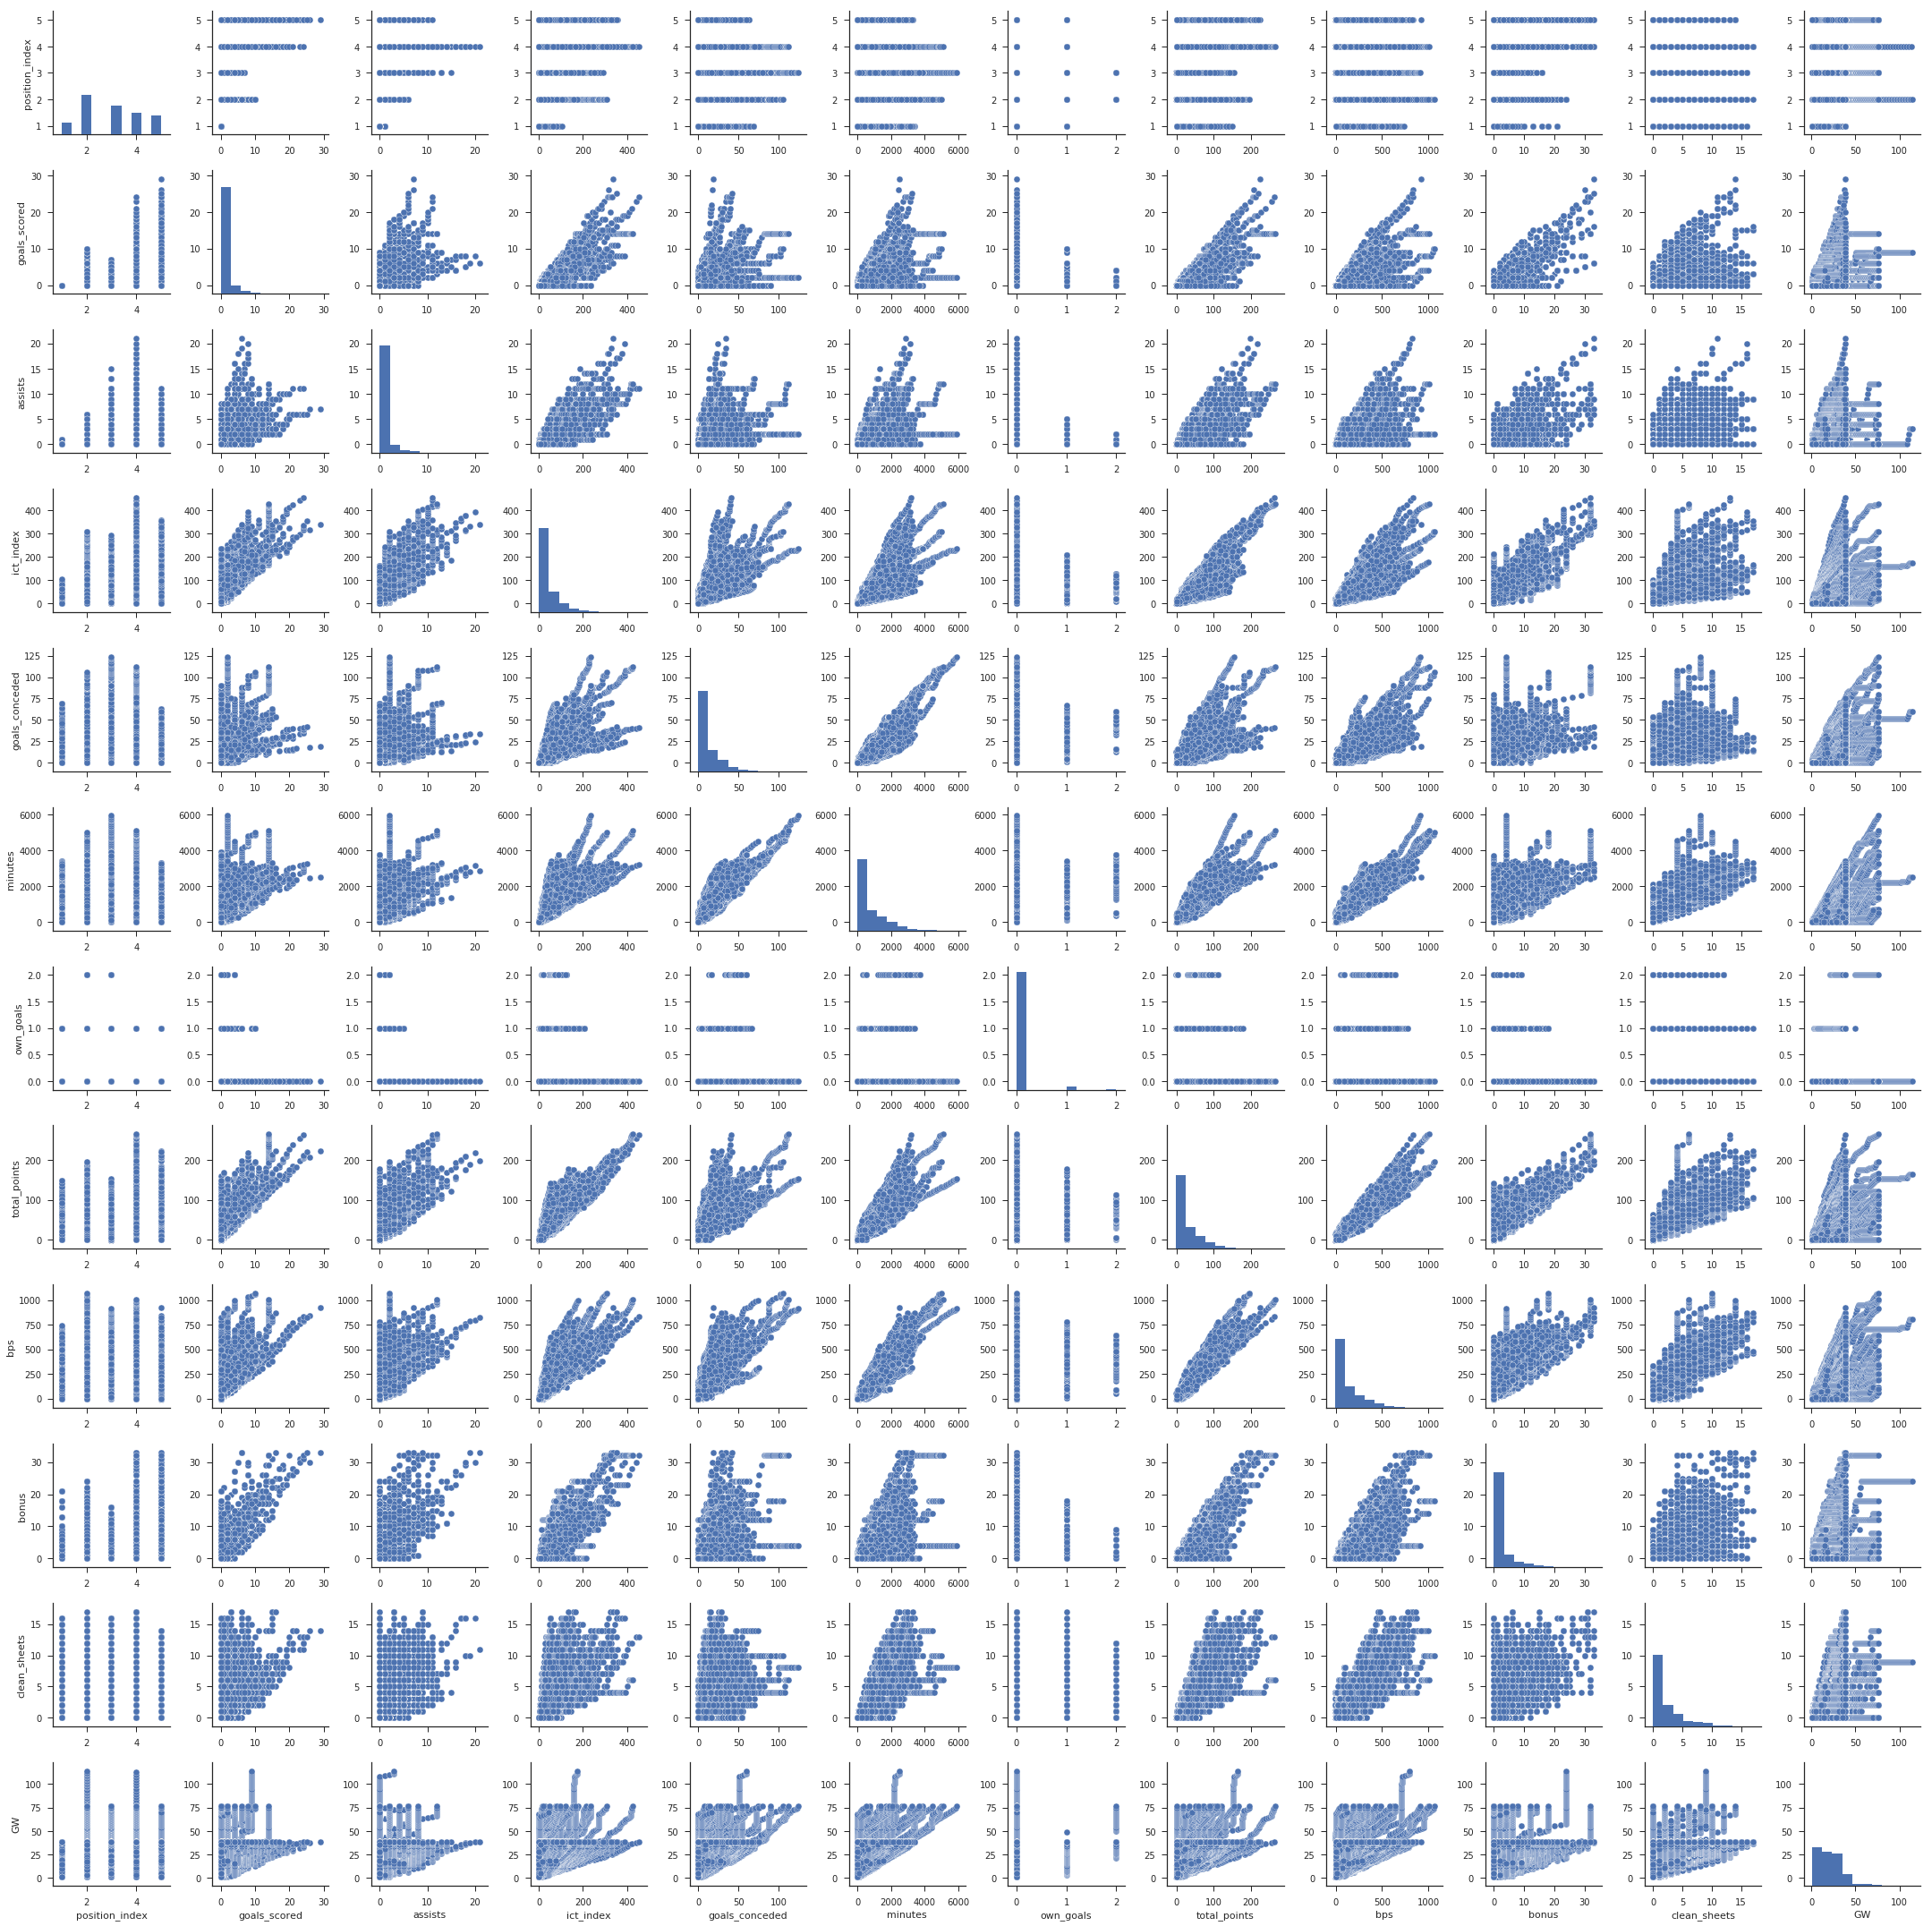

In [12]:
sns.pairplot(s17);

In [13]:
s17.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW'],
      dtype='object')

In [14]:
s17['fpl_to_game'] = (s17['total_points']/s17['minutes'])*90

In [15]:
s17_x, s17_y, s17_xm, s17_xtrain, s17_xtest, s17_ytrain, s17_ytest, s17_xtrain_new, s17_xtest_new = split_data(s17)

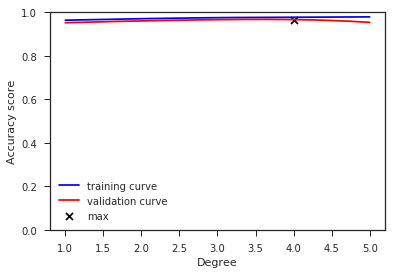

In [16]:
val_curve(model, s17_xm, s17_y)

In [17]:
model17 = make_pipeline(PolynomialFeatures(best_degree(model, s17_xm, s17_y)), LinearRegression())

In [18]:
s17_pred = model17.fit(s17_xtrain_new, s17_ytrain).predict(s17_xtest_new)

In [19]:
r2_score(s17_pred, s17_ytest)

0.97793354569141455

In [68]:
mean_squared_error(s17_pred, s17_ytest)

28.260107909651172

In [20]:
score17 = cross_val_score(model17, s17_xm, s17_y, cv = 5)
score17

array([ 0.92246984,  0.95342033,  0.96677291,  0.97331574,  0.96965084])

In [21]:
score17.mean()

0.95712593137878466

In [22]:
new_output(s17_xtest, s17_ytest, s17_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0  Marc Albrighton      113.9  376               3     1901      3   
1  Leighton Baines      128.3  593               2     2639     14   
2      Benik Afobe       42.3   59               5      390      1   
3   Fraser Forster        9.2  123               1      810      0   
4    Baily Cargill        0.4    5               2       13      0   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0            75     3.550763    72.399255          3.427634  
1           125     4.262978   112.259958          3.828494  
2            27     6.230769    23.902781          5.516026  
3            28     3.111111    24.797544          2.755283  
4             1     6.923077     0.840677          5.820070

## Premier League 2017/18

In [23]:
s18 = pd.read_csv("~/DSI-SRP1/FPL_2017_18_new.csv", encoding = "latin1")

In [24]:
s18.head()

Unnamed: 0      player_name          club_name          position  \
0           1  Aaron Cresswell    West Ham United         Left-Back   
1           2     Aaron Lennon         Everton FC      Right Winger   
2           3     Aaron Lennon         Burnley FC      Right Winger   
3           4       Aaron Mooy  Huddersfield Town  Central Midfield   
4           5     Aaron Ramsey         Arsenal FC  Central Midfield   

   position_index  goals_scored  assists  ict_index  goals_conceded  minutes  \
0               2             0        0        1.9               2        9   
1               4             0        0        0.0               0        0   
2               4             0        0        0.0               0        0   
3               3             0        1        8.7               0       90   
4               3             1        0        6.7               0       23   

   own_goals  total_points  bps  bonus  clean_sheets  GW  
0          0             0    3      0             0   1  
1          0             0    0      0             0   1  
2          0             0    0      0             0   2  
3          0             6   22      0             1   1  
4          0             6   16      0             0   1

In [25]:
s18 = s18.drop("Unnamed: 0", axis = 1)

In [26]:
s18.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW'],
      dtype='object')

In [27]:
s18.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.380489  0.259132   0.243343   
goals_scored          0.380489      1.000000  0.575097   0.785571   
assists               0.259132      0.575097  1.000000   0.803364   
ict_index             0.243343      0.785571  0.803364   1.000000   
goals_conceded       -0.026634      0.354914  0.432100   0.689958   
minutes              -0.015808      0.452448  0.543704   0.809125   
own_goals            -0.073304     -0.011447  0.007318   0.072448   
total_points          0.119519      0.711826  0.723219   0.925060   
bps                  -0.036171      0.540332  0.599328   0.845564   
bonus                 0.157438      0.781304  0.607650   0.791813   
clean_sheets          0.029516      0.494700  0.607799   0.788491   
GW                    0.054618      0.324248  0.382588   0.537894   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.026634 -0.015808  -0.073304      0.119519 -0.036171   
goals_scored          0.354914  0.452448  -0.011447      0.711826  0.540332   
assists               0.432100  0.543704   0.007318      0.723219  0.599328   
ict_index             0.689958  0.809125   0.072448      0.925060  0.845564   
goals_conceded        1.000000  0.928826   0.137404      0.762786  0.843003   
minutes               0.928826  1.000000   0.166104      0.902266  0.956819   
own_goals             0.137404  0.166104   1.000000      0.118217  0.166521   
total_points          0.762786  0.902266   0.118217      1.000000  0.949438   
bps                   0.843003  0.956819   0.166521      0.949438  1.000000   
bonus                 0.534100  0.659980   0.102423      0.846240  0.771991   
clean_sheets          0.618887  0.840947   0.140836      0.886825  0.877649   
GW                    0.611200  0.621973   0.063139      0.579896  0.587915   

                   bonus  clean_sheets        GW  
position_index  0.157438      0.029516  0.054618  
goals_scored    0.781304      0.494700  0.324248  
assists         0.607650      0.607799  0.382588  
ict_index       0.791813      0.788491  0.537894  
goals_conceded  0.534100      0.618887  0.611200  
minutes         0.659980      0.840947  0.621973  
own_goals       0.102423      0.140836  0.063139  
total_points    0.846240      0.886825  0.579896  
bps             0.771991      0.877649  0.587915  
bonus           1.000000      0.678605  0.377086  
clean_sheets    0.678605      1.000000  0.478208  
GW              0.377086      0.478208  1.000000

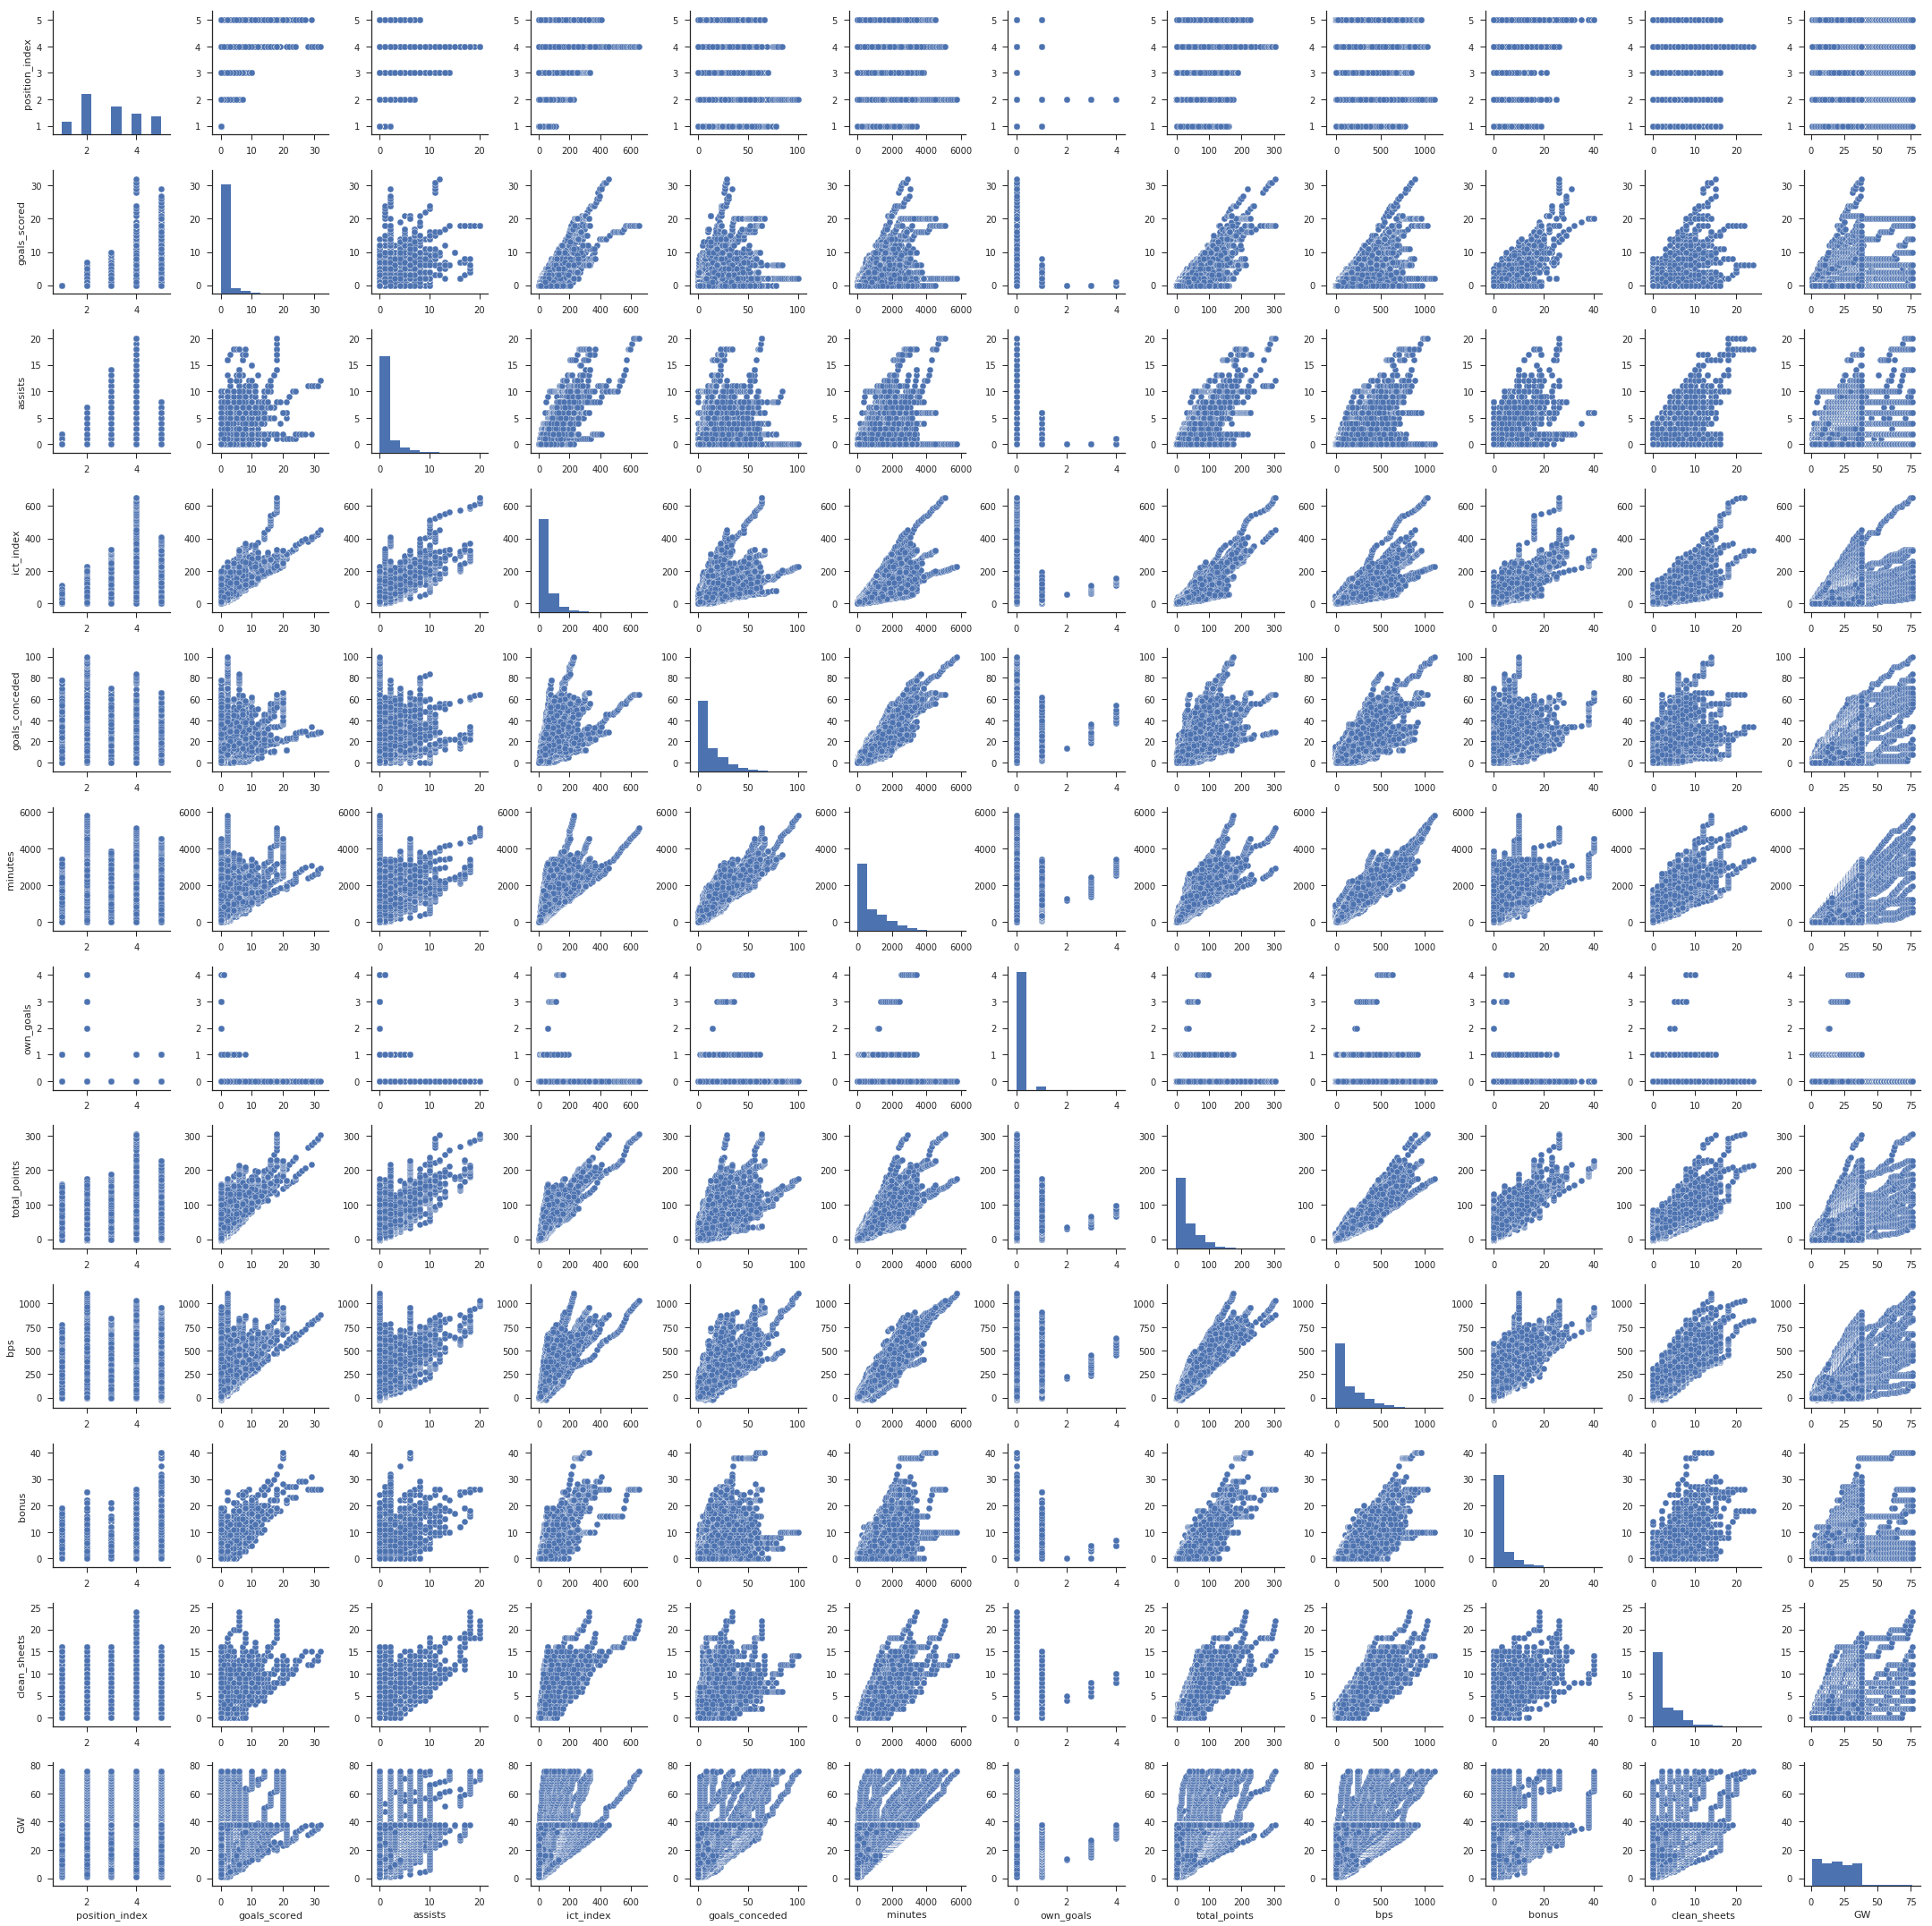

In [28]:
sns.pairplot(s18);

In [29]:
s18['fpl_to_game'] = (s18['total_points']/s18['minutes'])*90

In [30]:
s18_x, s18_y, s18_xm, s18_xtrain, s18_xtest, s18_ytrain, s18_ytest, s18_xtrain_new, s18_xtest_new = split_data(s18)

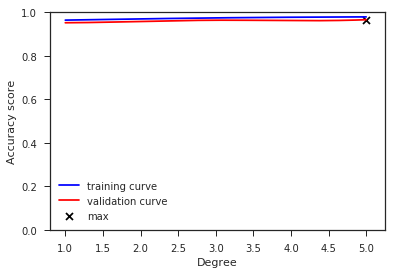

In [31]:
val_curve(model, s18_xm, s18_y)

In [32]:
model18 = make_pipeline(PolynomialFeatures(best_degree(model, s18_xm, s18_y)), LinearRegression())

In [33]:
s18_pred = model18.fit(s18_xtrain_new, s18_ytrain).predict(s18_xtest_new)

In [34]:
r2_score(s18_pred, s18_ytest)

0.97704903121737852

In [35]:
score18 = cross_val_score(model18, s18_xm, s18_y, cv = 5)
score18

array([ 0.91801428,  0.94872966,  0.96639618,  0.97177449,  0.96623027])

In [36]:
score18.mean()

0.95422897797946238

In [37]:
new_output(s18_xtest, s18_ytest, s18_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0     George Thomas        0.0    0               4        0      0   
1        Phil Jones       47.5  489               2     1793     16   
2      Kyle Bartley       10.5   25               2      210      0   
3  Thibaut Courtois       27.4  326               1     1620      2   
4       Benik Afobe       16.9   55               5      374      0   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0             0          NaN     0.747609               inf  
1           101     5.069716   103.791364          5.209829  
2             4     1.714286     4.178766          1.790900  
3            74     4.111111    68.198110          3.788784  
4            18     4.331551    17.602757          4.235958

## Premier League 2018/19

In [38]:
s19 = pd.read_csv("~/DSI-SRP1/FPL_2018_19_new.csv", encoding = "latin1")

In [39]:
s19.head()

Unnamed: 0        player_name          club_name          position  \
0           1    Aaron Cresswell    West Ham United         Left-Back   
1           2       Aaron Lennon         Burnley FC      Right Winger   
2           3         Aaron Mooy  Huddersfield Town  Central Midfield   
3           4       Aaron Ramsey         Arsenal FC  Central Midfield   
4           5  Aaron Wan-Bissaka     Crystal Palace        Right-Back   

   position_index  goals_scored  assists  ict_index  goals_conceded  minutes  \
0               2             0        0        0.0               0        0   
1               4             0        0        3.9               0       90   
2               3             0        0        3.8               3       90   
3               3             0        0        2.9               1       53   
4               2             0        1        6.0               0       90   

   own_goals  total_points  bps  bonus  clean_sheets  GW  
0          0             0    0      0             0   1  
1          0             3    6      0             1   1  
2          0             2   24      0             0   1  
3          0             1    7      0             0   1  
4          0            12   38      3             1   1

In [40]:
s19 = s19.drop("Unnamed: 0", axis = 1)

In [41]:
s19.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW'],
      dtype='object')

In [42]:
s19.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.366623  0.257346   0.240875   
goals_scored          0.366623      1.000000  0.614799   0.817368   
assists               0.257346      0.614799  1.000000   0.763252   
ict_index             0.240875      0.817368  0.763252   1.000000   
goals_conceded       -0.042856      0.375512  0.324619   0.671652   
minutes              -0.040500      0.466847  0.476012   0.804556   
own_goals            -0.091957     -0.002492  0.054368   0.105299   
total_points          0.100121      0.721478  0.685490   0.919314   
bps                  -0.065144      0.533849  0.564753   0.833492   
bonus                 0.119335      0.739209  0.671226   0.807236   
clean_sheets         -0.006013      0.449742  0.525349   0.737969   
GW                    0.007329      0.240494  0.079127   0.286268   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.042856 -0.040500  -0.091957      0.100121 -0.065144   
goals_scored          0.375512  0.466847  -0.002492      0.721478  0.533849   
assists               0.324619  0.476012   0.054368      0.685490  0.564753   
ict_index             0.671652  0.804556   0.105299      0.919314  0.833492   
goals_conceded        1.000000  0.896266   0.217899      0.719208  0.787266   
minutes               0.896266  1.000000   0.215798      0.893076  0.952073   
own_goals             0.217899  0.215798   1.000000      0.112765  0.189795   
total_points          0.719208  0.893076   0.112765      1.000000  0.943759   
bps                   0.787266  0.952073   0.189795      0.943759  1.000000   
bonus                 0.467479  0.659343   0.088000      0.850533  0.780875   
clean_sheets          0.535286  0.824788   0.110952      0.851406  0.862235   
GW                    0.457941  0.331268   0.030757      0.345202  0.295872   

                   bonus  clean_sheets        GW  
position_index  0.119335     -0.006013  0.007329  
goals_scored    0.739209      0.449742  0.240494  
assists         0.671226      0.525349  0.079127  
ict_index       0.807236      0.737969  0.286268  
goals_conceded  0.467479      0.535286  0.457941  
minutes         0.659343      0.824788  0.331268  
own_goals       0.088000      0.110952  0.030757  
total_points    0.850533      0.851406  0.345202  
bps             0.780875      0.862235  0.295872  
bonus           1.000000      0.682350  0.098274  
clean_sheets    0.682350      1.000000  0.127667  
GW              0.098274      0.127667  1.000000

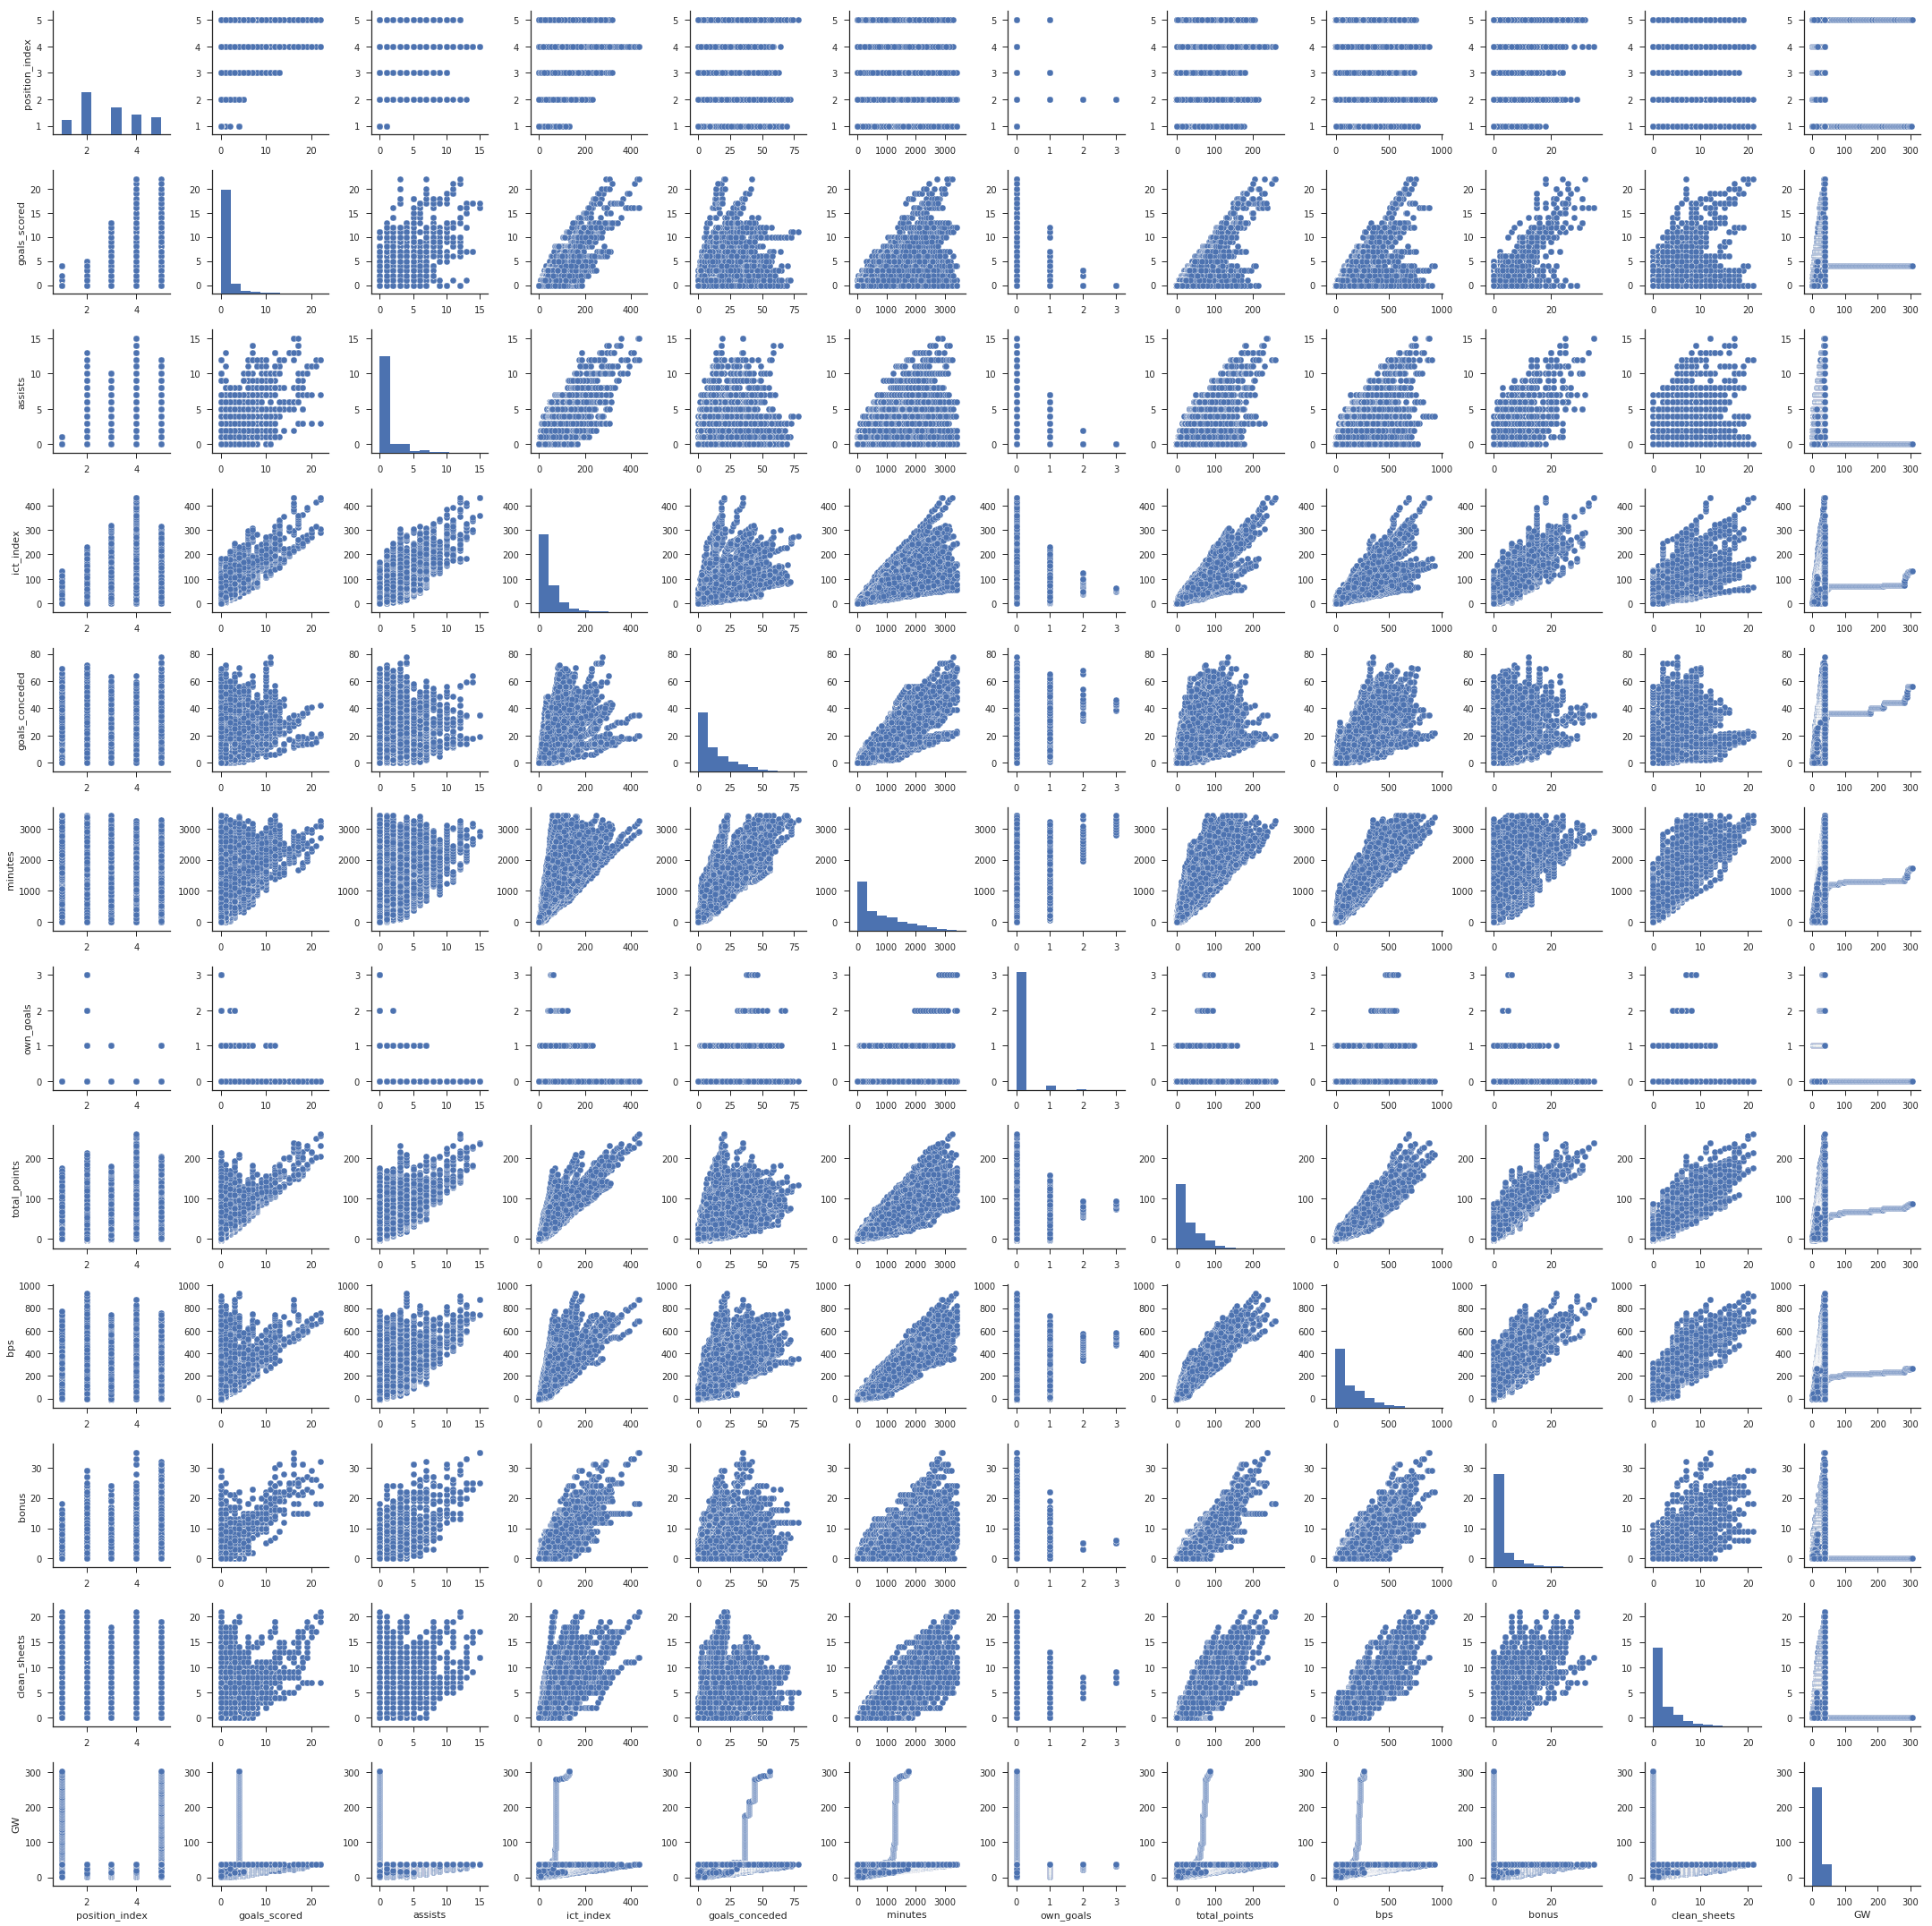

In [43]:
sns.pairplot(s19);

In [44]:
s19['fpl_to_game'] = (s19['total_points']/s19['minutes'])*90

In [45]:
s19_x, s19_y, s19_xm, s19_xtrain, s19_xtest, s19_ytrain, s19_ytest, s19_xtrain_new, s19_xtest_new = split_data(s19)

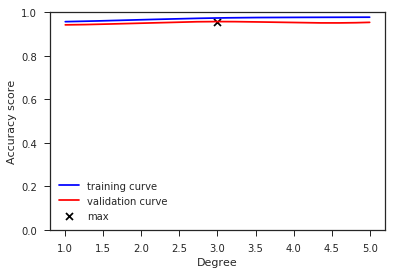

In [46]:
val_curve(model, s19_xm, s19_y)

In [47]:
model19 = make_pipeline(PolynomialFeatures(best_degree(model, s19_xm, s19_y)), LinearRegression())

In [48]:
s19_pred = model19.fit(s19_xtrain_new, s19_ytrain).predict(s19_xtest_new)

In [49]:
r2_score(s19_pred, s19_ytest)

0.97144552209352364

In [50]:
score19 = cross_val_score(model19, s19_xm, s19_y, cv = 5)
score19

array([ 0.93244241,  0.95013883,  0.96217827,  0.96695621,  0.95758507])

In [51]:
score19.mean()

0.9538601565139514

In [52]:
new_output(s19_xtest, s19_ytest, s19_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0              Beram Kayal       31.4  124               3      792      0   
1           Victor Wanyama        5.1   25               3      147      0   
2          Victor Lindelöf       68.3  495               2     2428      9   
3             Marc Navarro        2.2    8               2       83      0   
4  Pedro Rodríguez Ledesma       85.0  233               4      805      9   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0            31     3.522727    23.293118          2.646945  
1             6     3.673469     4.792844          2.934394  
2            81     3.002471    89.672631          3.323944  
3             1     1.084337     0.451562          0.489646  
4            68     7.602484    67.740235          7.573442

## COMBINED SEASONS

In [53]:
scom = pd.concat([s17, s18, s19], axis = 0)

In [54]:
scom.head()

player_name        club_name          position  position_index  \
0     Aaron Cresswell  West Ham United         Left-Back               2   
1        Aaron Lennon       Everton FC      Right Winger               4   
2        Aaron Ramsey       Arsenal FC  Central Midfield               3   
3  Abdoulaye Doucouré       Watford FC  Central Midfield               3   
4   Abdul Rahman Baba       Chelsea FC         Left-Back               2   

   goals_scored  assists  ict_index  goals_conceded  minutes  own_goals  \
0             0        0        0.0               0        0          0   
1             0        0        0.9               0       15          0   
2             0        0        3.0               3       60          0   
3             0        0        0.0               0        0          0   
4             0        0        0.0               0        0          0   

   total_points  bps  bonus  clean_sheets  GW  fpl_to_game  
0             0    0      0             0   1          NaN  
1             1    6      0             0   1          6.0  
2             2    5      0             0   1          3.0  
3             0    0      0             0   1          NaN  
4             0    0      0             0   1          NaN

In [55]:
scom.shape

(59230, 16)

In [56]:
scom.corr()

position_index  goals_scored   assists  ict_index  \
position_index        1.000000      0.349565  0.248772   0.220744   
goals_scored          0.349565      1.000000  0.579492   0.792318   
assists               0.248772      0.579492  1.000000   0.782219   
ict_index             0.220744      0.792318  0.782219   1.000000   
goals_conceded       -0.037609      0.393905  0.409108   0.714349   
minutes              -0.037312      0.470162  0.521711   0.820102   
own_goals            -0.097695     -0.002507  0.011901   0.084454   
total_points          0.092388      0.719647  0.700672   0.924881   
bps                  -0.063340      0.544245  0.577413   0.845839   
bonus                 0.124804      0.772146  0.627525   0.807123   
clean_sheets          0.002060      0.473877  0.554299   0.762769   
GW                    0.023295      0.263952  0.217250   0.394152   
fpl_to_game           0.119138      0.028913  0.001638  -0.062144   

                goals_conceded   minutes  own_goals  total_points       bps  \
position_index       -0.037609 -0.037312  -0.097695      0.092388 -0.063340   
goals_scored          0.393905  0.470162  -0.002507      0.719647  0.544245   
assists               0.409108  0.521711   0.011901      0.700672  0.577413   
ict_index             0.714349  0.820102   0.084454      0.924881  0.845839   
goals_conceded        1.000000  0.919431   0.189518      0.763894  0.832938   
minutes               0.919431  1.000000   0.192419      0.903475  0.956339   
own_goals             0.189518  0.192419   1.000000      0.117995  0.178307   
total_points          0.763894  0.903475   0.117995      1.000000  0.947817   
bps                   0.832938  0.956339   0.178307      0.947817  1.000000   
bonus                 0.531915  0.662947   0.084060      0.852340  0.778811   
clean_sheets          0.600418  0.837683   0.126547      0.869392  0.869280   
GW                    0.502791  0.459203   0.057838      0.443087  0.427818   
fpl_to_game          -0.163368 -0.154758  -0.042859     -0.066225 -0.106890   

                   bonus  clean_sheets        GW  fpl_to_game  
position_index  0.124804      0.002060  0.023295     0.119138  
goals_scored    0.772146      0.473877  0.263952     0.028913  
assists         0.627525      0.554299  0.217250     0.001638  
ict_index       0.807123      0.762769  0.394152    -0.062144  
goals_conceded  0.531915      0.600418  0.502791    -0.163368  
minutes         0.662947      0.837683  0.459203    -0.154758  
own_goals       0.084060      0.126547  0.057838    -0.042859  
total_points    0.852340      0.869392  0.443087    -0.066225  
bps             0.778811      0.869280  0.427818    -0.106890  
bonus           1.000000      0.673141  0.244603    -0.005370  
clean_sheets    0.673141      1.000000  0.312280    -0.086907  
GW              0.244603      0.312280  1.000000    -0.039056  
fpl_to_game    -0.005370     -0.086907 -0.039056     1.000000

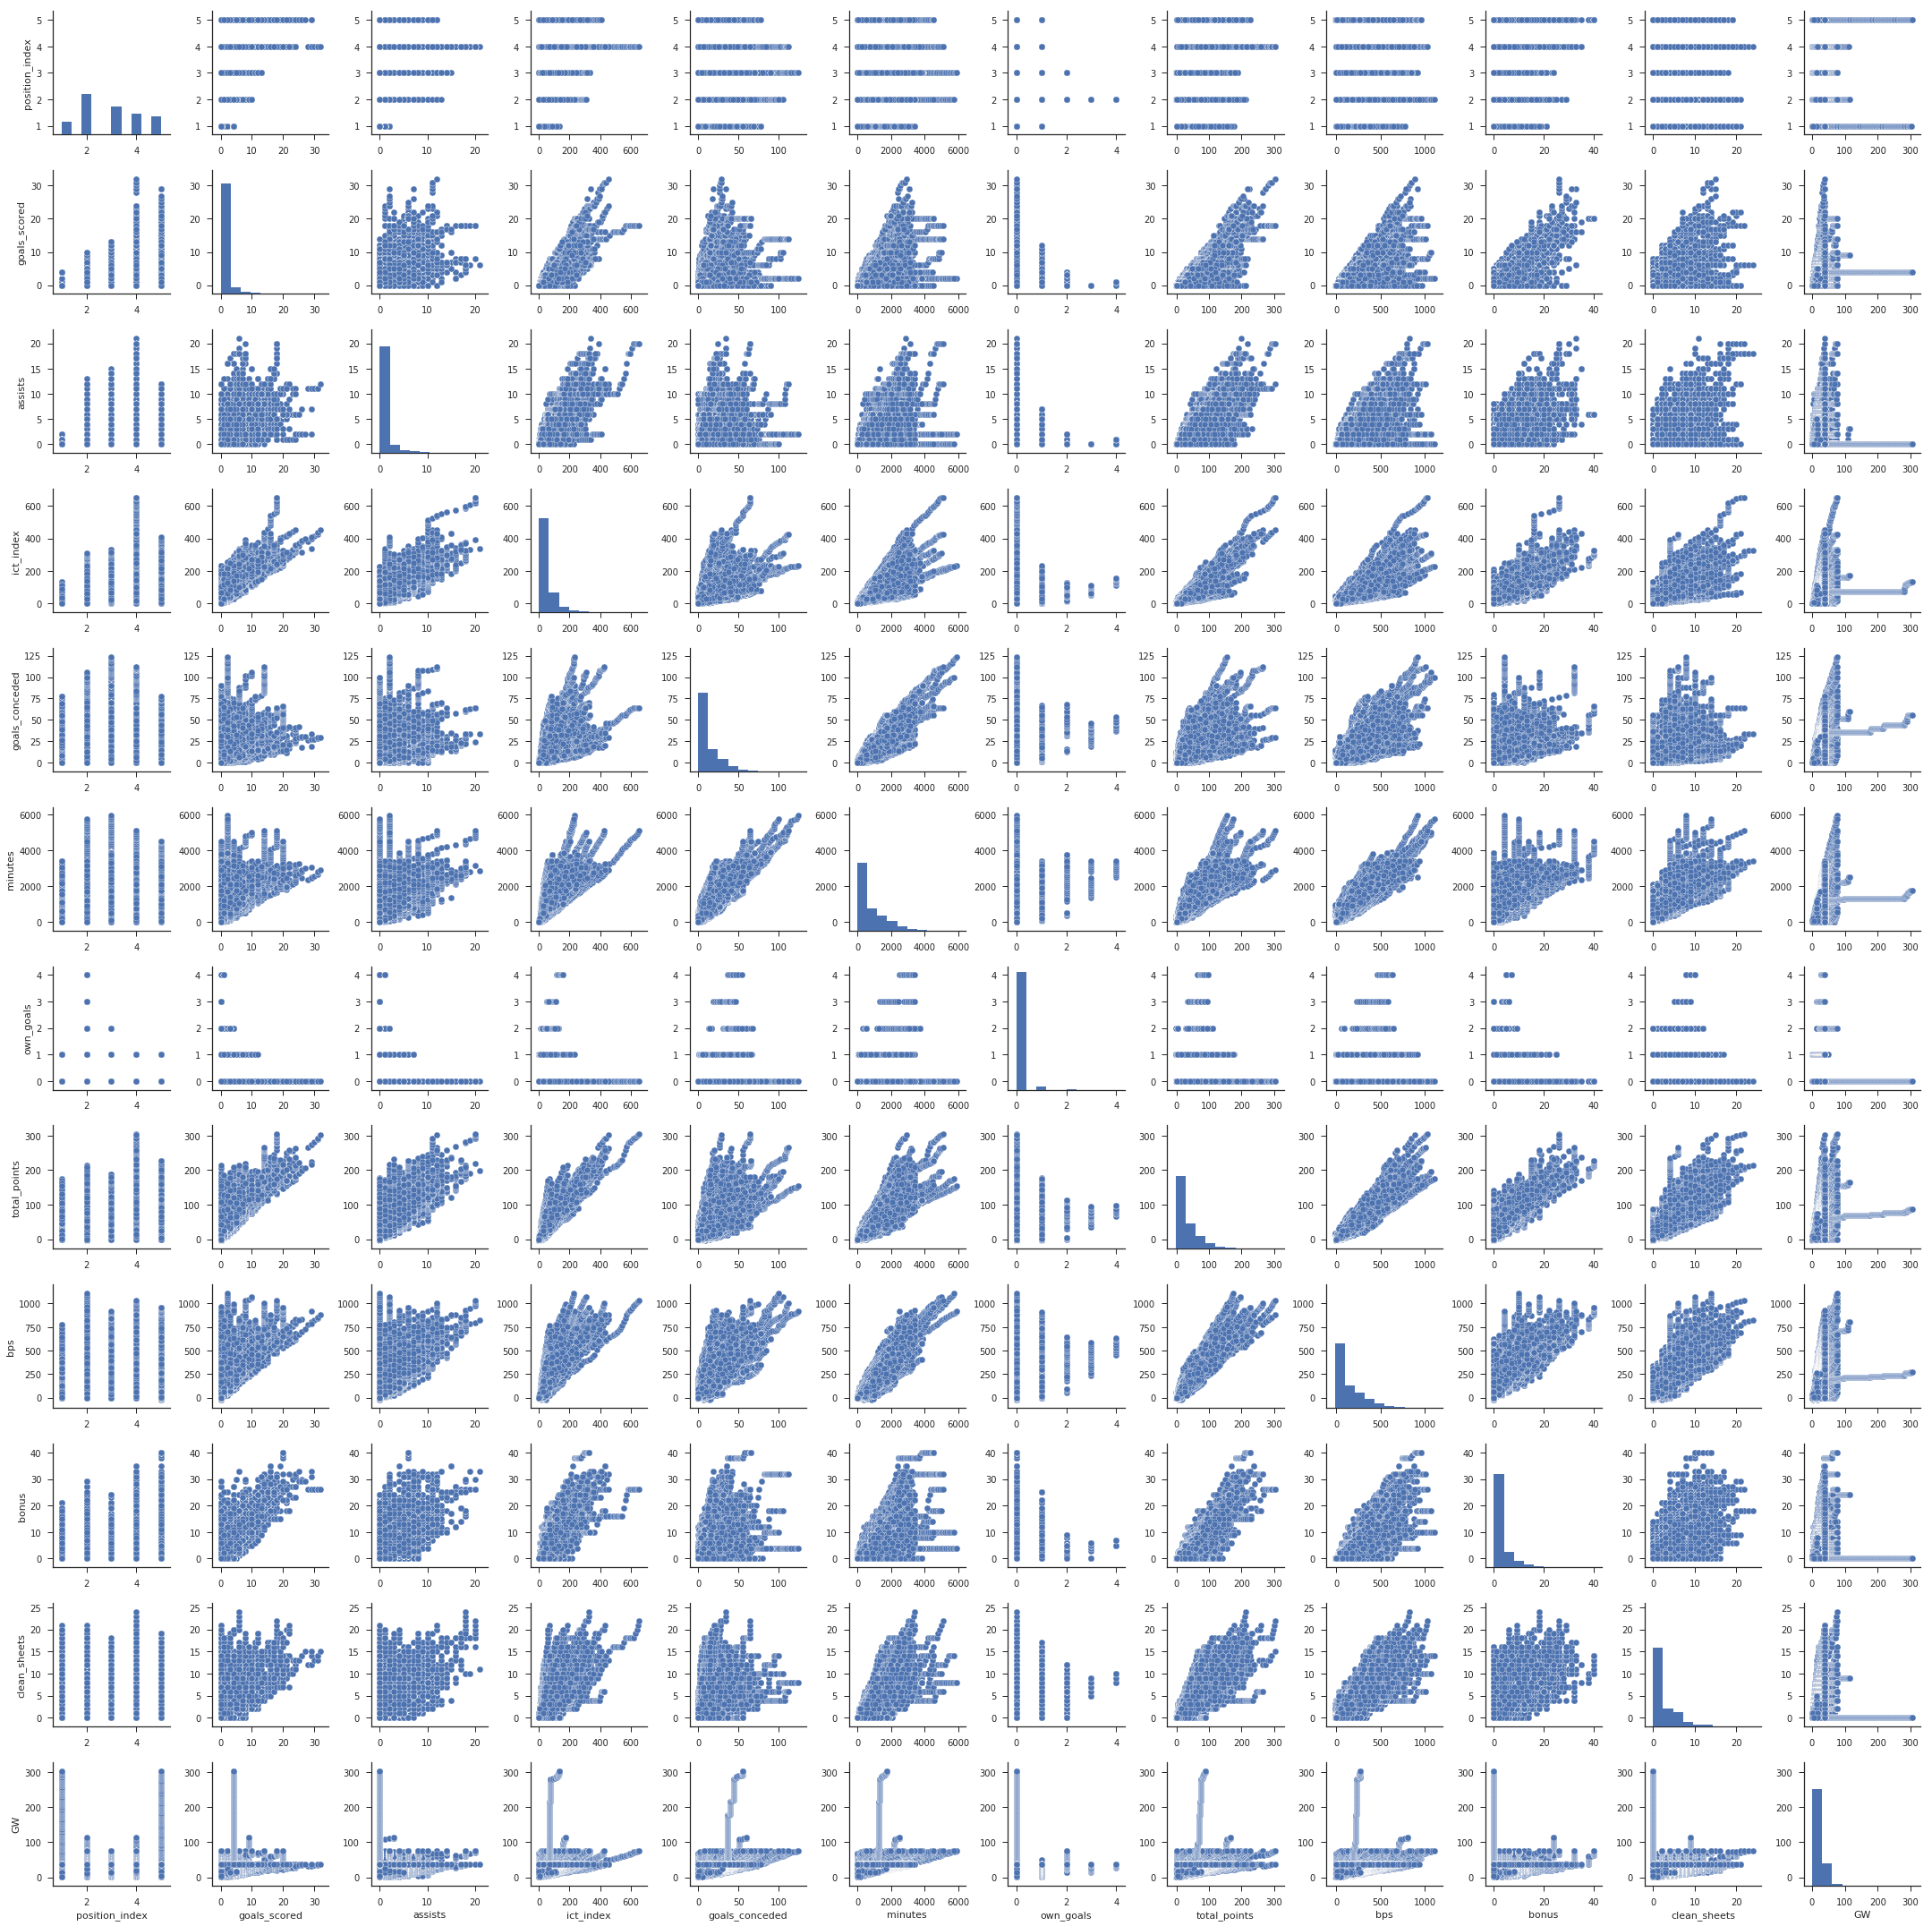

In [57]:
sns.pairplot(scom.drop('fpl_to_game', axis = 1));

In [58]:
scom_x, scom_y, scom_xm, scom_xtrain, scom_xtest, scom_ytrain, scom_ytest, scom_xtrain_new, scom_xtest_new = split_data(scom,10)

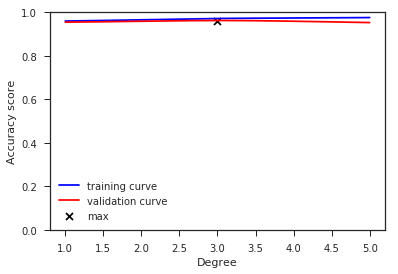

In [59]:
val_curve(model, scom_xm, scom_y)

In [60]:
model_s = make_pipeline(PolynomialFeatures(best_degree(model, scom_xm, scom_y)), LinearRegression())

In [61]:
scom_pred = model_s.fit(scom_xtrain_new, scom_ytrain).predict(scom_xtest_new)

In [62]:
r2_score(scom_pred, scom_ytest)

0.97149399228834477

In [63]:
score_com = cross_val_score(model_s, scom_xm, scom_y, cv = 5)
score_com

array([ 0.95565363,  0.97257669,  0.96244761,  0.97439411,  0.95740167])

In [64]:
score_com.mean()

0.96449474073454122

In [65]:
new_output(scom_xtest, scom_ytest, scom_pred)

player_name  ict_index  bps  position_index  minutes  bonus  \
0  Anthony Martial       70.9  182               4      618     11   
1     Jason Lokilo        0.0    0               4        0      0   
2   James Morrison        2.7    4               3       21      0   
3  Vincent Kompany       26.1  148               2      674      0   
4   Craig Cathcart       96.1  512               2     2834      5   

   total_points  fpl_to_game  pred_points  fpl_to_game pred  
0            58     8.446602    58.403464          8.505359  
1             0          NaN     1.497437               inf  
2             2     8.571429     1.497699          6.418709  
3            24     3.204748    23.663074          3.159758  
4            91     2.889908    84.385557          2.679852